In [ ]:
!unzip /content/drive/MyDrive/tiger_croped.zip
!pip install hdbscan

In [2]:
import multiprocessing
import torch
import time
import math
import cv2
import numpy
import json
import random
import tqdm
import os

import torchvision.models as models
import torchvision.transforms as transforms
from sklearn import preprocessing
from torch.nn import functional as F
from PIL import Image, ImageOps
from datetime import datetime
from pathlib import Path

import numpy as np

DEBUG = True

os.environ["TORCH_HOME"] = os.environ["TORCH_HOME"] if "TORCH_HOME" in os.environ else os.path.join(".", ".torch")
MSEC_IN_HOUR = 60 * 60 * 1000
DEFAULT_IMG_SIZE = (
    224,
    224,
)
VGG_CHUNK_SIZE_PX = 32
VGG_IMG_SIZE = 768
# VGG_IMG_SIZE = 1440

class VGG19Img2Vec:
    def __init__(self, cuda=False, layer="default", pretrained=True, **kwargs):
        """Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.model = models.vgg19(pretrained=pretrained, **kwargs)
        self.model = self.model.to(self.device)
        self.model.eval()
        self.layer_name = 3 if layer == "default" else int(layer)
        self.extraction_layer = self.model.classifier[self.layer_name]
        self.layer_output_size = 4096
        self.resizer = transforms.Resize(VGG_IMG_SIZE, interpolation=2)
        self.normalize = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
        )

    def forward_hook(self, key):
        def forward_hook_(module, input, output):
            # Save feature maps
            self.fmap_pool[key] = output.detach()

        return forward_hook_

    def get_vec(self, images, tensor=False):
        with torch.no_grad():
            preprocessed_images = []
            for img_path in images:
                img = Image.open(img_path).convert("RGB")
                img_height, img_width = img.size

                scaled_img = self.resizer(img)
                nim = self.normalize(scaled_img)
                if (len(preprocessed_images) == 0) or (preprocessed_images[-1][-1].shape != nim.shape):
                    preprocessed_images.append([])
                preprocessed_images[-1].append(nim)
            result = []

            for preprocessed_images_group in preprocessed_images:
                torch_input = torch.stack(preprocessed_images_group).to(self.device)
                embedding = torch.zeros(len(preprocessed_images_group), self.layer_output_size)

                def copy_data(m, i, o):
                    embedding.copy_(o.data)

                print("PyTorch memory allocated:", torch.cuda.max_memory_allocated())
                h = self.extraction_layer.register_forward_hook(copy_data)
                t1 = time.time()
                self.model(torch_input)
                h.remove()
                if tensor:
                    result += [embedding[x, :] for x in range(embedding.shape[0])]
                else:
                    enp = embedding.numpy()
                    result += [enp[x, :] for x in range(enp.shape[0])]
                print("model execution %d ms" % int((time.time() - t1) * 1000))
            return result

In [3]:
img2vec = VGG19Img2Vec(cuda=True, layer="default")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to ./.torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
from glob import glob

img_paths = glob('./tiger_croped/*')[:800]
vectors = img2vec.get_vec(img_paths)

# clustering

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(vectors)
clusterer.labels_

In [13]:
from collections import Counter

counts = Counter(clusterer.labels_)
counts.most_common(8)

[(-1, 455), (4, 243), (6, 24), (8, 22), (2, 20), (7, 12), (5, 8), (1, 6)]

In [124]:
from PIL import Image

indexes = []
classes_img_paths = {}
classes_imgs = {}
labels = []
vectors_classes = np.expand_dims(vectors[0], 0)
count = 0
for elem in clusterer.labels_:
  if elem != -1 and elem != 4:
    indexes.append(count)
    labels.append(elem)
    img_paths_temp = classes_img_paths.get(elem, [])
    img_paths_temp.append(img_paths[count])

    imgs_temp = classes_imgs.get(elem, [])
    img = Image.open(img_paths[count])
    img.thumbnail((384,384))
    imgs_temp.append(np.array(img))
    classes_imgs[elem] = imgs_temp

    classes_img_paths[elem] = img_paths_temp
    vectors_classes = np.concatenate((vectors_classes, np.expand_dims(vectors[count], 0)), 0)
  # class_vectors = classes.get(elem, np.array())
  # img_paths[count]
  # classes[elem] = 
  if count == 1:
    vectors_classes = vectors_classes[1:, :]
  count += 1

# visualization

In [63]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components_3dim = pca.fit_transform(vectors_classes)
x3dim, y3dim, z3dim = [component[0] for component in components_3dim],\
                      [component[1] for component in components_3dim],\
                      [component[2] for component in components_3dim]

pca = PCA(n_components=2)
components_2dim = pca.fit_transform(vectors_classes)
x2dim, y2dim = [component[0] for component in components_2dim], \
               [component[1] for component in components_2dim]

In [64]:
fig = px.scatter_3d(x = x3dim, y = y3dim, z=z3dim, color=labels)
fig.update_traces(marker_coloraxis=None)
fig.show()

In [65]:
fig = px.scatter(x = x2dim, y = y2dim, color=labels)
fig.update_traces(marker_coloraxis=None)
fig.show()

# what animals do we have on those classes?

In [107]:
from random import sample
import matplotlib.pyplot as plt

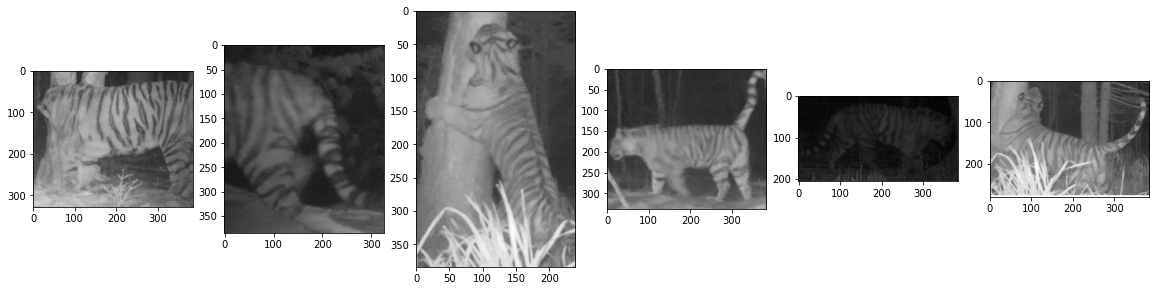

In [136]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

f, axarr = plt.subplots(1, 6)
rand_slice_2class = sample(classes_imgs[2], 6)
for i in range(6):
  axarr[i].imshow(rand_slice_2class[i])
plt.show()

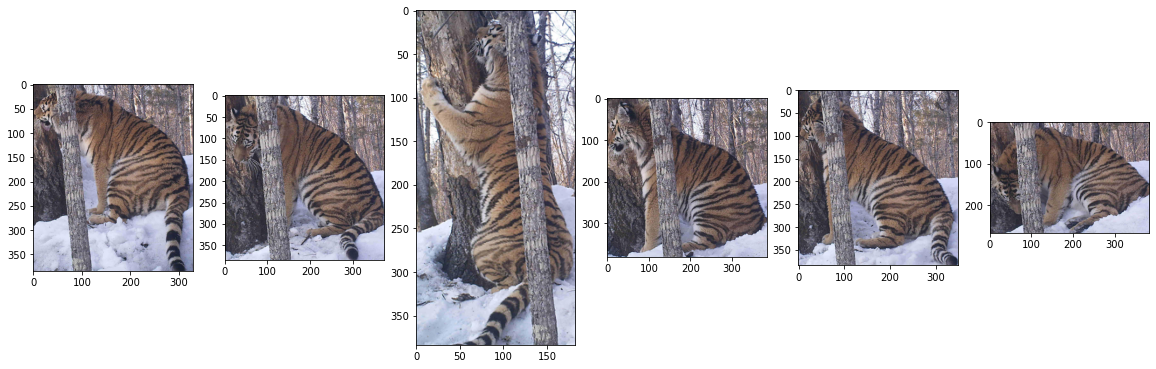

In [134]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

f, axarr = plt.subplots(1, 6)
rand_slice_6class = sample(classes_imgs[6], 6)
for i in range(6):
  axarr[i].imshow(rand_slice_6class[i])
plt.show()

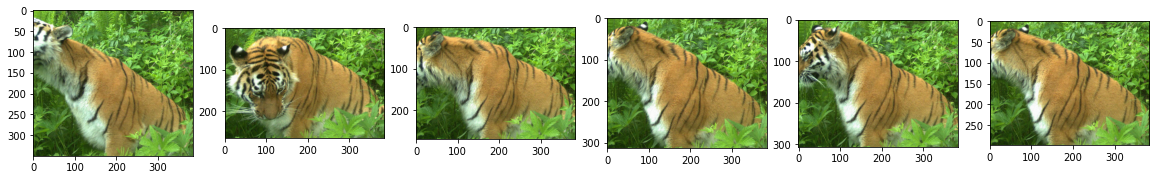

In [125]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

f, axarr = plt.subplots(1, 6)
rand_slice_7class = sample(classes_imgs[7], 6)
for i in range(6):
  axarr[i].imshow(rand_slice_7class[i])
plt.show()

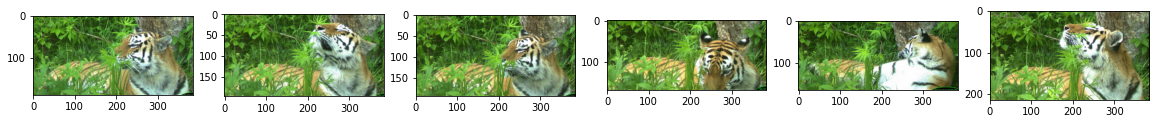

In [127]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

f, axarr = plt.subplots(1, 6)
rand_slice_8class = sample(classes_imgs[8], 6)
for i in range(6):
  axarr[i].imshow(rand_slice_8class[i])
plt.show()

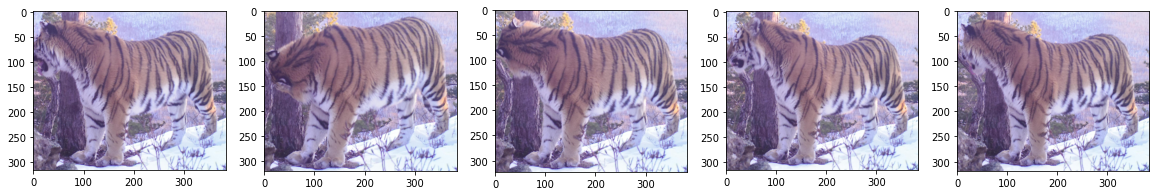

In [132]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

f, axarr = plt.subplots(1, 5)
rand_slice_3class = sample(classes_imgs[3], 5)
for i in range(5):
  axarr[i].imshow(rand_slice_3class[i])
plt.show()